# Projekt ML grupy RANDOOM

Założeniem projektu było utworzenie modelu, który na podstawie danych historycznych zebranych przez czujnik powietrza, będzie przewidywał jakość powietrza.

## Zbiór danych

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import datetime
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# read data to dataframe
df = pd.read_excel('../pyly_2.xlsx', sheet_name='Worksheet')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7102 entries, 0 to 7101
Data columns (total 21 columns):
ID czujnika        7102 non-null int64
AQI                7102 non-null int64
PM1                7102 non-null int64
PM25               7102 non-null int64
PM10               7102 non-null int64
O3                 7102 non-null int64
CO                 7102 non-null int64
SO2                7102 non-null int64
NO2                7102 non-null int64
C6H6               7102 non-null int64
CH2O               7102 non-null int64
Temperatura        7102 non-null int64
Wilgotność         7102 non-null int64
Ciśnienie          7102 non-null int64
Prędkość wiatru    7102 non-null int64
Wind bearing       7102 non-null int64
Szerokość geo.     7102 non-null float64
Wysokość geo.      7102 non-null float64
Czas mierzenia     7102 non-null object
Epoch              7102 non-null int64
is_forecast        7102 non-null int64
dtypes: float64(2), int64(18), object(1)
memory usage: 1.1+ MB


## Preprocessing #1

In [2]:
# add columns - hour, day of the week, month
df['Godzina'] = df['Czas mierzenia'].apply(lambda x: int(datetime.datetime.strptime(x, '%m/%d/%Y %H:%M').time().hour))
df['Dzień tygodnia'] = df['Czas mierzenia'].apply(lambda x: int(datetime.datetime.strptime(x, '%m/%d/%Y %H:%M').date().weekday()))
df['Miesiąc'] = df['Czas mierzenia'].apply(lambda x: int(datetime.datetime.strptime(x, '%m/%d/%Y %H:%M').date().month))

df2 = df['Czas mierzenia'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %H:%M'))

# prediction time offset
offset = 12

# droping first three rows od data set - not clean values
df = df.drop(df.index[[0, 1, 2]])
df = df.reset_index(drop=True)

# creating target data (y) for train and test
df['PM10_P'] = df['PM10'].shift(periods=-offset)
y = df['PM10_P'].dropna()

# removing columns unused columns from data set
columns_to_delete = ["ID czujnika", "AQI", "O3", "CO", "SO2", "NO2", "C6H6", "CH2O", "Szerokość geo.", "Wysokość geo.", "Epoch", "is_forecast", "Czas mierzenia", "PM10_P"]
df = df.drop(columns=columns_to_delete, axis=1)

# creating train, test data set
X = df[:-offset]

#creating data set for predictions
X_prog = df[-offset:]


# split data set into train and test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=101)

## Preprocessing #2

In [3]:
# ----------------------------------------------------------------------
# PREDICTION - DEFAULT PARAMETERS, ALL FEATURES
print('---- PREDICTION - DEFAULT PARAMETERS, ALL FEATURES ----')
# def prediction(model, model_name):
#     model.fit(train_X, train_y)

#     pred_test_y = model.predict(test_X)
#     pred_y = model.predict(X)
#     prog_y = model.predict(X_prog)

#     mae = mean_absolute_error(test_y, pred_test_y)

#     print("Mean Absolute Error for {}:  {}".format(model_name, mae))
    
def prediction(model, model_name, wykres=False):
    model.fit(train_X, train_y)

    pred_test_y = model.predict(test_X)
    pred_y = model.predict(X)
    prog_y = model.predict(X_prog)

    mae = mean_absolute_error(test_y, pred_test_y)

    print("Mean Absolute Error for {}:  {}".format(model_name, mae))


    if wykres==True:
        plt.figure(figsize=(10, 10))
        plt.title('Dopasowanie modelu dla '+model_name)
        plt.plot(df2[-50 - offset:-offset].values, y[-50:], label='real')
        plt.plot(df2[-50 - offset:-offset].values, pred_y[-50:], label='pred')
        # plt.plot(np.arange(50, 51+offset, 1), np.concatenate([pred_y[-1].ravel(), prog_y.ravel()]), label='prog')
        plt.xlabel('Data i godzina')
        plt.ylabel('PM 10')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.title('Prognoza dla '+model_name)
        plt.plot(df2[-50 - offset:-offset].values, y[-50:], label='real')
        # plt.plot(np.arange(1, 51, 1), pred_y[-50:], label='pred')
        plt.plot(df2[-1 - offset:].values, np.concatenate([y[-1:], prog_y.ravel()]), label='prog')
        plt.xlabel('Data i godzina')
        plt.ylabel('PM 10')
        plt.legend()
        plt.show()

# Prediction for LinearRegression
model_linreg = LinearRegression()
prediction(model_linreg, 'Linear Regression')

# Prediction for DecisionTreeRegressor
model_dtreg = DecisionTreeRegressor(random_state=101)
prediction(model_dtreg, 'Decision Tree Regressor')

# Prediction for Random Forest Regressor
model_rf = RandomForestRegressor(random_state=101)
prediction(model_rf, 'Random Forest Regressor')

# Prediction for XGBoost Regressor
model_xgb = XGBRegressor(random_state=101)
prediction(model_xgb, 'XGBoost Regressor')


---- PREDICTION - DEFAULT PARAMETERS, ALL FEATURES ----
Mean Absolute Error for Linear Regression:  17.367298591303516
Mean Absolute Error for Decision Tree Regressor:  11.664315937940762
Mean Absolute Error for Random Forest Regressor:  10.287658674189
Mean Absolute Error for XGBoost Regressor:  12.75933836747292


### Preprocessing #3

---- FEATURE SELECTION ----
Najlepsze Cechy: ['PM1' 'PM25' 'PM10' 'Temperatura' 'Wilgotność' 'Ciśnienie'
 'Prędkość wiatru' 'Wind bearing' 'Godzina' 'Dzień tygodnia' 'Miesiąc']


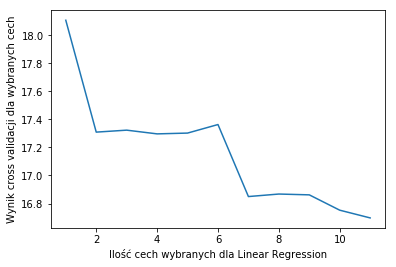

Najlepsze Cechy: ['PM1' 'PM10' 'Temperatura' 'Ciśnienie' 'Prędkość wiatru' 'Wind bearing'
 'Godzina' 'Dzień tygodnia' 'Miesiąc']


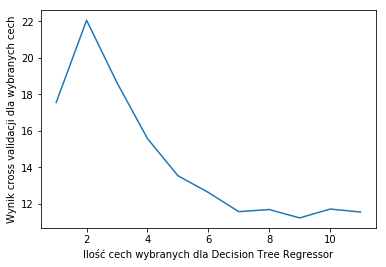

Najlepsze Cechy: ['PM1' 'PM10' 'Temperatura' 'Wilgotność' 'Ciśnienie' 'Prędkość wiatru'
 'Wind bearing' 'Godzina' 'Dzień tygodnia' 'Miesiąc']


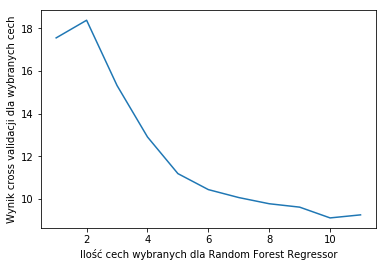

Najlepsze Cechy: ['PM1' 'PM25' 'PM10' 'Temperatura' 'Wilgotność' 'Ciśnienie'
 'Prędkość wiatru' 'Wind bearing' 'Godzina' 'Dzień tygodnia' 'Miesiąc']


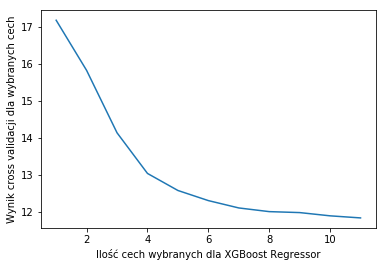

In [4]:
# ----------------------------------------------------------------------
# FEATURE SELECTION
print('---- FEATURE SELECTION ----')


def feature_selection(model, model_name):
    xs = train_X
    ys = train_y

    rfecv = RFECV(estimator=model, scoring='neg_mean_absolute_error', cv=10)
    rfecv = rfecv.fit(xs, ys.values.flatten())

    print("Najlepsze Cechy:", xs.columns[rfecv.support_].values)

    plt.figure()
    plt.xlabel("Ilość cech wybranych dla "+model_name)
    plt.ylabel("Wynik cross validacji dla wybranych cech")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), abs(rfecv.grid_scores_))
    plt.show()

# Feature selection for LinearRegression
model_linreg = LinearRegression()
feature_selection(model_linreg, 'Linear Regression')

# Feature selection for DecisionTreeRegressor
model_dtreg = DecisionTreeRegressor(random_state=101)
feature_selection(model_dtreg, 'Decision Tree Regressor')

# Feature selection for Random Forest Regressor
model_rf = RandomForestRegressor(random_state=101)
feature_selection(model_rf, 'Random Forest Regressor')

# Feature selection for XGBoost Regressor
model_xgb = XGBRegressor(random_state=101)
feature_selection(model_xgb, 'XGBoost Regressor')

## Preprocessing #4

In [5]:
# ----------------------------------------------------------------------
# PREDICTION - DEFAULT PARAMETERS, LIMITED FEATURES
print('---- PREDICTION - DEFAULT PARAMETERS, LIMITED FEATURES ----')

# Prediction for LinearRegression
# Optymalna ilość cech dla Linear Regression 11
# all features selected
X = df[:-offset]
X_prog = df[-offset:]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=101)
model_linreg = LinearRegression()
prediction(model_linreg, 'Linear Regression')

# Prediction for DecisionTreeRegressor
# Optymalna ilość cech dla Decision Tree Regressor 10
# excluding PM25 feature
X = df[:-offset]
X_prog = df[-offset:]
X = X.drop('PM25', axis=1)
X_prog = X_prog.drop('PM25', axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=101)
model_dtreg = DecisionTreeRegressor(random_state=101)
prediction(model_dtreg, 'Decision Tree Regressor')

# Prediction for Random Forest Regressor
# Optymalna ilość cech dla XGBoost Regressor 11
# all features selected
X = df[:-offset]
X_prog = df[-offset:]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=101)
model_rf = RandomForestRegressor(random_state=101)
prediction(model_rf, 'Random Forest Regressor')

# Prediction for XGBoost Regressor
# Optymalna ilość cech dla XGBoost Regressor 10
# excluding PM25 feature
X = df[:-offset]
X_prog = df[-offset:]
X = X.drop('PM25', axis=1)
X_prog = X_prog.drop('PM25', axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=101)
model_xgb = XGBRegressor(random_state=101)
prediction(model_xgb, 'XGBoost Regressor')

---- PREDICTION - DEFAULT PARAMETERS, LIMITED FEATURES ----
Mean Absolute Error for Linear Regression:  17.367298591303516
Mean Absolute Error for Decision Tree Regressor:  11.824400564174894
Mean Absolute Error for Random Forest Regressor:  10.287658674189
Mean Absolute Error for XGBoost Regressor:  12.857918047350115


## Parameters tuning

In [6]:
# ----------------------------------------------------------------------
# PARAMETERES TUNNING
print('---- PARAMETERES TUNNING ----')

def select_model(X, Y):
    best_models = {}
    models = [
        # {
        #     'name': 'LinearRegression',
        #     'estimator': LinearRegression(),
        #     'hyperparameters': {},
        # },
        {
            'name': 'Decision Tree Regressor',
            'estimator': DecisionTreeRegressor(),
            'hyperparameters': {
                'criterion': ['mae'],
                'max_features': ['auto'],
                'min_samples_leaf': [1, 2, 5],
                'min_samples_split': [2, 4, 6],
            }
        },
        {
            'name': 'RandomForest',
            'estimator': RandomForestRegressor(),
            'hyperparameters': {
                'bootstrap': ['True'],
                'criterion': ['mae'],
                'max_features': ['auto'],
                'min_samples_leaf': [1, 2, 5],
                'min_samples_split': [2, 4, 6],
                'n_estimators': [10, 20, 100]

            }
        },
        {
            'name': 'XGBoost',
            'estimator': XGBRegressor(),
            'hyperparameters': {
                'gamma': [i / 10.0 for i in range(0, 5)],
                'learning_rate': [0.01, 0.1, 0.2],
                'n_estimators': range(100, 200, 10),
                'max_depth': [3, 5, 7, 9],
                'min_child_weight': [1, 3, 5, 6]
            }
        }

    ]

    for model in models:
        print('\n', '-'*20, '\n', model['name'])
        start = time.perf_counter()
        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=5, scoring="neg_mean_absolute_error",
                            verbose=False, n_jobs=-1)
        grid.fit(train_X.values, train_y.values)
        best_models[model['name']] = {'score': grid.best_score_, 'params': grid.best_params_}
        run = time.perf_counter() - start
        print('mea: {}\n{}'.format(str(abs(grid.best_score_)), str(grid.best_params_)))

    return best_models


X = df[:-offset]
X = X.drop('PM25', axis=1)

# best = select_model(X, y)

import pickle

with open('best.pickle', 'rb') as f:
    best = pickle.load(f)
for model, data in best.items():
    print('\n', '-'*20, '\n', model)
    print('mea: {}\n{}'.format(str(abs(data['score'])), str(data['params'])))

---- PARAMETERES TUNNING ----

 -------------------- 
 Decision Tree Regressor
mea: 12.19359675427765
{'criterion': 'mae', 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 4}

 -------------------- 
 RandomForest
mea: 9.769582818839302
{'bootstrap': 'True', 'criterion': 'mae', 'max_features': 'auto', 'n_estimators': 100}

 -------------------- 
 XGBoost
mea: 11.912651080979222
{'min_child_weight': 3}


## Feature engineering

In [7]:
X = df[:-offset]
X_prog = df[-offset:]
X = X.drop('PM25', axis=1)
X_prog = X_prog.drop('PM25', axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=101)
model = RandomForestRegressor(random_state=101)
print('Przed FE')
prediction(model, 'RandomForestRegressor')

Przed FE
Mean Absolute Error for RandomForestRegressor:  10.227997179125529


In [8]:
X = df[:-offset]
X['TC'] = X['Temperatura']*X['Ciśnienie']
X_prog = df[df.shape[0]-offset:]
X_prog['TC'] = X_prog['Temperatura']*X_prog['Ciśnienie']
columns_to_delete = ['PM25','Wilgotność','Temperatura']
X = X.drop(columns=columns_to_delete, axis=1)
X_prog = X_prog.drop(columns=columns_to_delete, axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=101)
model = RandomForestRegressor(random_state=101)
print('Po FE')
prediction(model, 'RandomForestRegressor')

Po FE
Mean Absolute Error for RandomForestRegressor:  10.075669957686884


## Prezentacja wybranego modelu

### RandomForestRegressor

Mean Absolute Error for RandomForestRegressor:  10.075669957686884


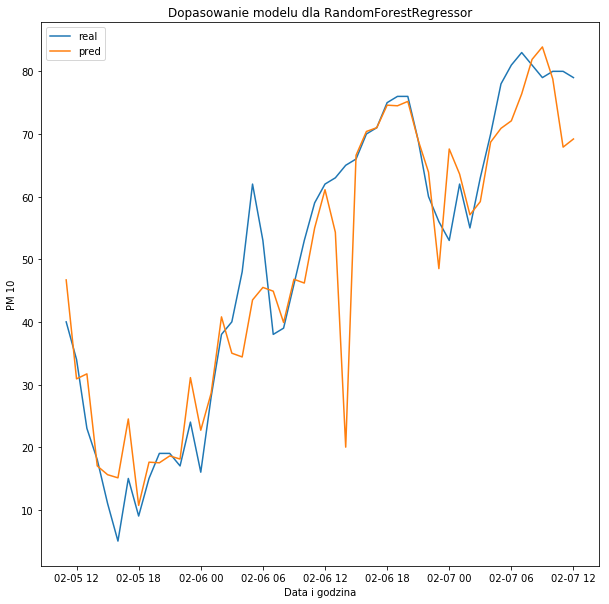

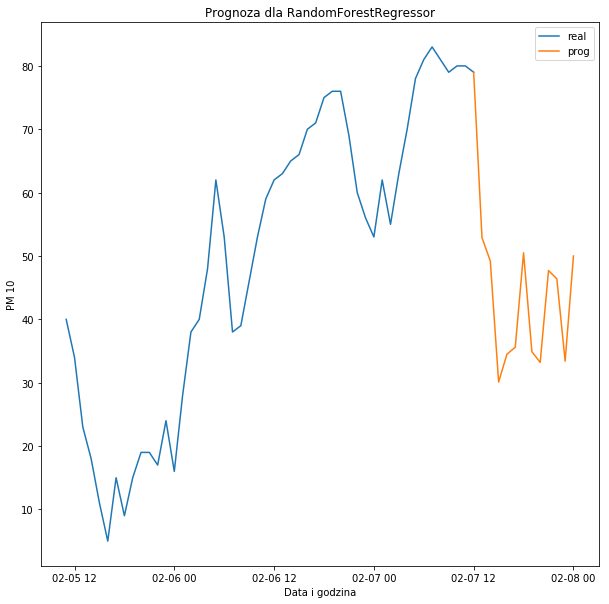

In [9]:
X = df[:-offset]
X['TC'] = X['Temperatura']*X['Ciśnienie']
X_prog = df[df.shape[0]-offset:]
X_prog['TC'] = X_prog['Temperatura']*X_prog['Ciśnienie']
columns_to_delete = ['PM25','Wilgotność','Temperatura']
X = X.drop(columns=columns_to_delete, axis=1)
X_prog = X_prog.drop(columns=columns_to_delete, axis=1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=101)
model = RandomForestRegressor(random_state=101)
prediction(model, 'RandomForestRegressor', wykres=True)

## Predykcja naiwna

11.306870642547581


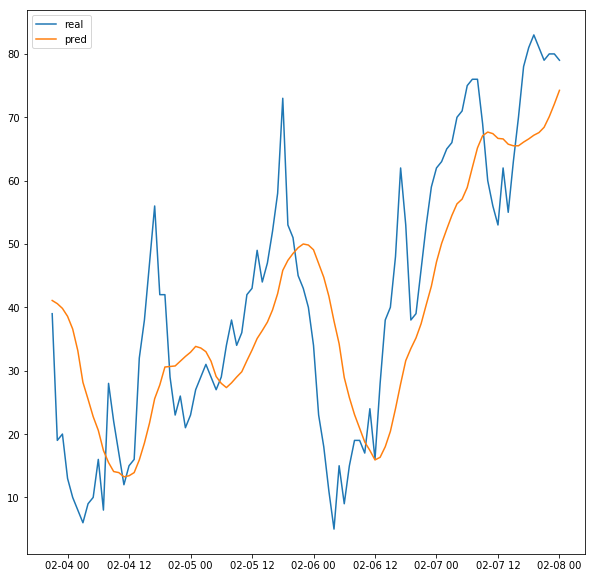

In [10]:
#Średnia Krocząca

def movingavg(values, window):
    weights = np.repeat(1.0, window)/window
    smas = np.convolve(values, weights, 'valid')
    return smas


sk = y
krok = 12

por_sk = y[krok-1:]

pred_sk = movingavg(sk, krok)

mse = sum(abs(pred_sk - por_sk))/len(por_sk)

print(mse)

czas_x = df2[krok-1+3:]

plt.figure(figsize=(10, 10))
plt.plot(czas_x[-100:].values, por_sk[-100:], label = 'real')
plt.plot(czas_x[-100:].values, pred_sk[-100:], label = 'pred')
# plt.xticks(rotation = 40)
# ax1 = plt.axes()
# ax1.axes.get_xaxis().set_visible(False)
plt.legend()
plt.show()